In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch

In [2]:
def read_binary_video(file_path, width=256, height=64, channels=3):
    """Read a binary video file into numpy array [frames, height, width, channels]."""
    with open(file_path, "rb") as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    frame_size = width * height * channels
    frame_count = len(data) // frame_size
    video = data[:frame_count * frame_size].reshape((frame_count, height, width, channels))
    return video

In [3]:
def extract_mean_signal(video):
    """Extract mean green channel intensity as raw signal."""
    green_channel = video[:, :, :, 1]  # take green channel
    signal = green_channel.mean(axis=(1, 2))  # average over pixels
    return signal

In [4]:
def bandpass_filter(signal, fs=60, low=0.7, high=4.0, order=5):
    """Apply Butterworth bandpass filter to signal."""
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)

In [5]:
def estimate_bpm(signal, fs=60):
    """Estimate BPM using Welch power spectrum."""
    freqs, psd = welch(signal, fs=fs, nperseg=fs*4)
    mask = (freqs >= 0.7) & (freqs <= 4.0)
    peak_freq = freqs[mask][np.argmax(psd[mask])]
    bpm = peak_freq * 60
    return bpm, freqs, psd

In [6]:
def process_file(file_path, label, patient_id, results):
    """Process one patient file and plot results."""
    video = read_binary_video(file_path)
    raw_signal = extract_mean_signal(video)
    filtered = bandpass_filter(raw_signal)
    bpm, freqs, psd = estimate_bpm(filtered)

In [7]:
def process_file(file_path, label, patient_id, results):
    """Process one patient file and plot results."""
    video = read_binary_video(file_path)
    raw_signal = extract_mean_signal(video)
    filtered = bandpass_filter(raw_signal)
    bpm, freqs, psd = estimate_bpm(filtered)
    # Save results
    results.append({"Region": label, "Patient": patient_id, "BPM": bpm})

    # --- Plot ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 6))
    axes[0].plot(raw_signal)
    axes[0].set_title(f"{label} - Patient {patient_id}: Raw Signal")
    axes[1].plot(filtered)
    axes[1].set_title("Filtered Signal (0.7–4 Hz)")
    axes[2].plot(freqs, psd)
    axes[2].set_xlim(0, 5)
    axes[2].set_title(f"Power Spectrum (Estimated BPM={bpm:.1f})")
    plt.tight_layout()
    plt.show()
    return results

In [8]:
def process_folder(folder_path, label, results):
    """Process all patient files in a folder."""
    for i, filename in enumerate(sorted(os.listdir(folder_path))):
        if filename.endswith(".bin"):
            file_path = os.path.join(folder_path, filename)
            results = process_file(file_path, label, i+1, results)
    return results

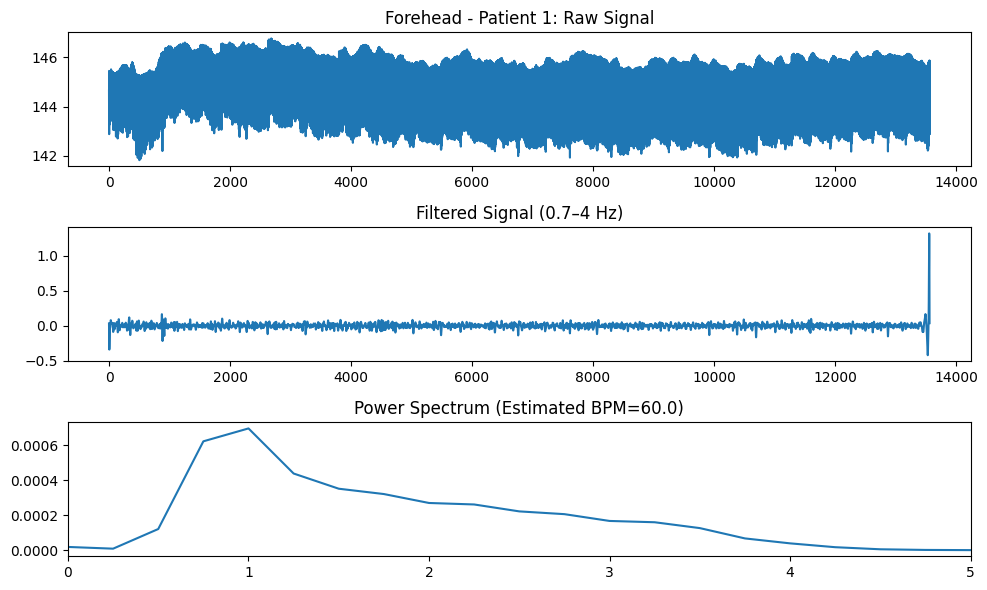

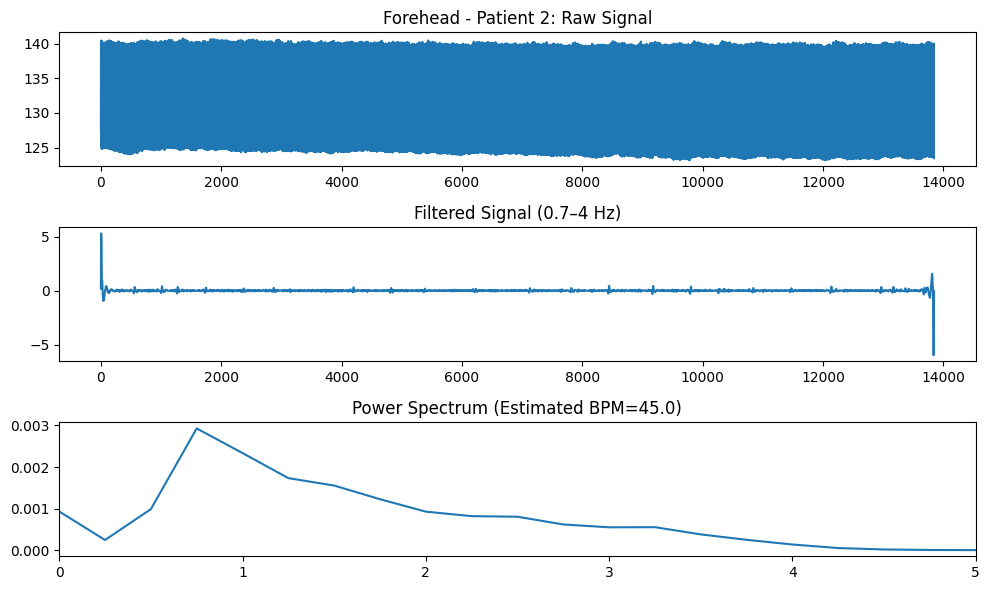

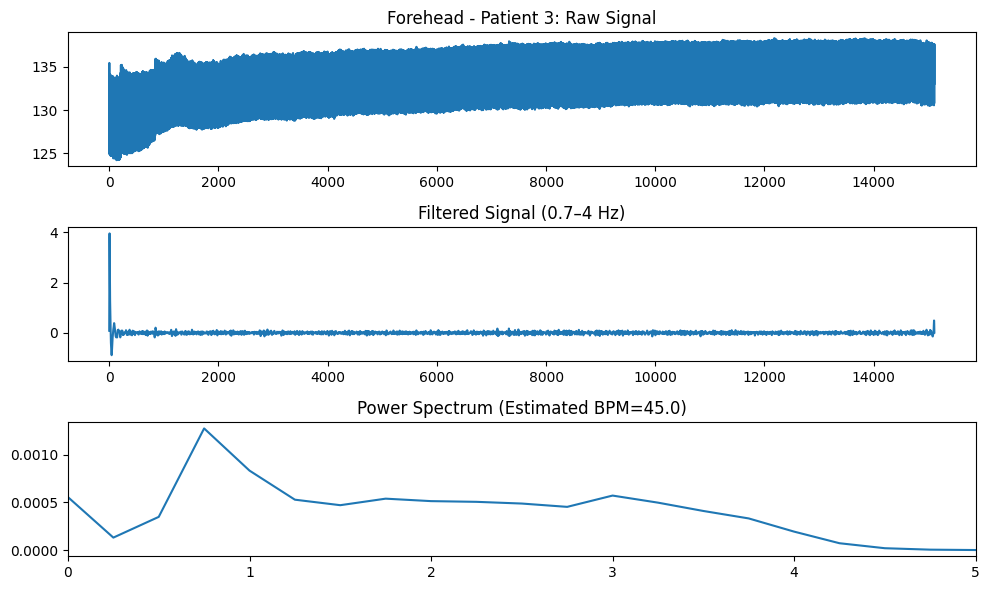

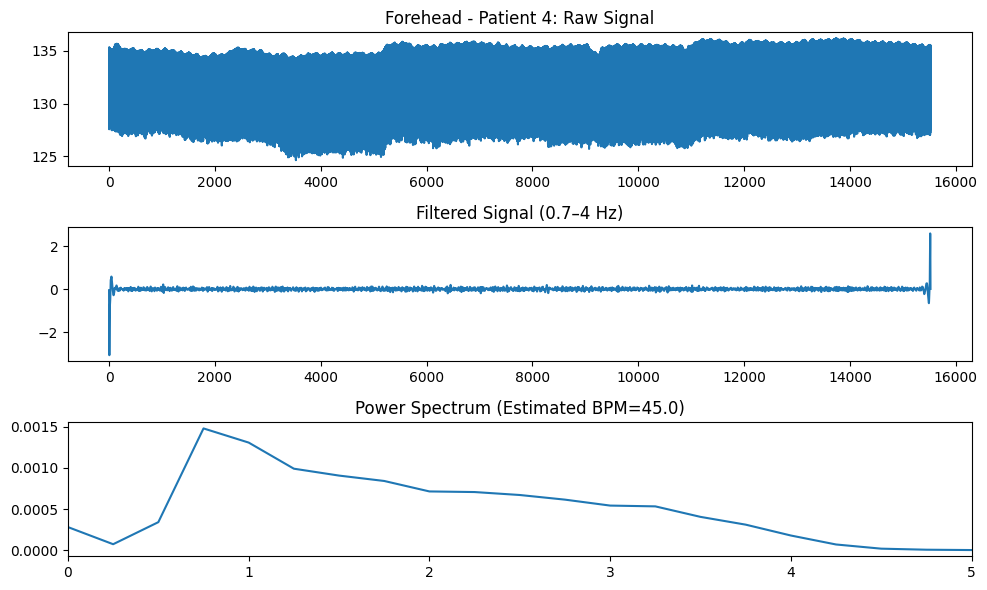

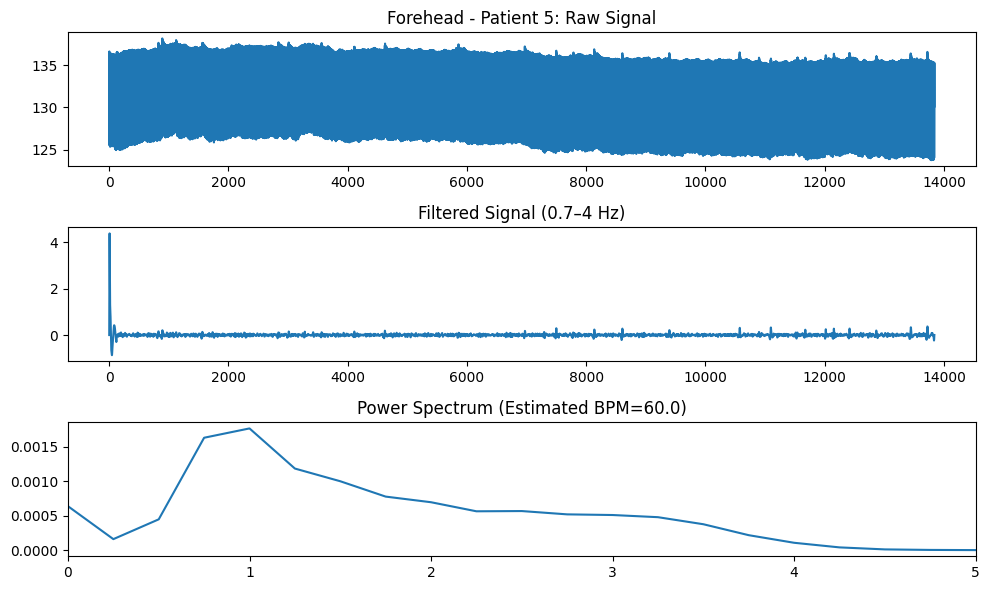

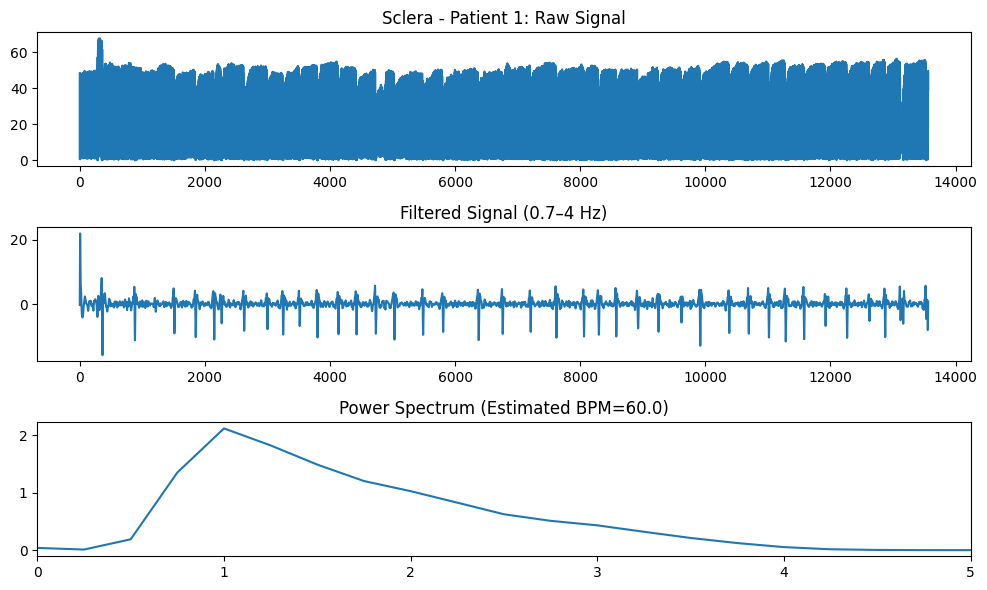

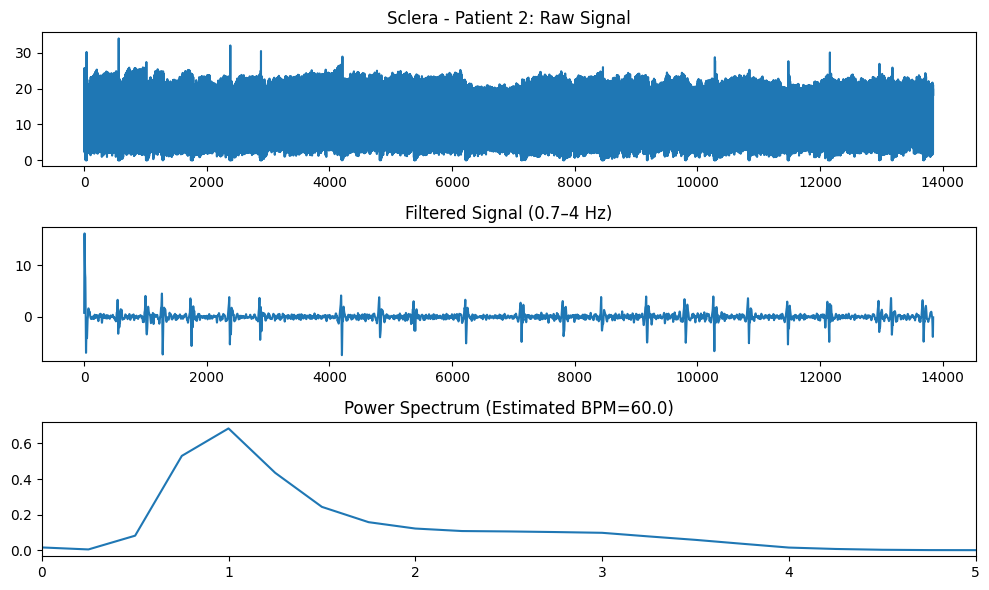

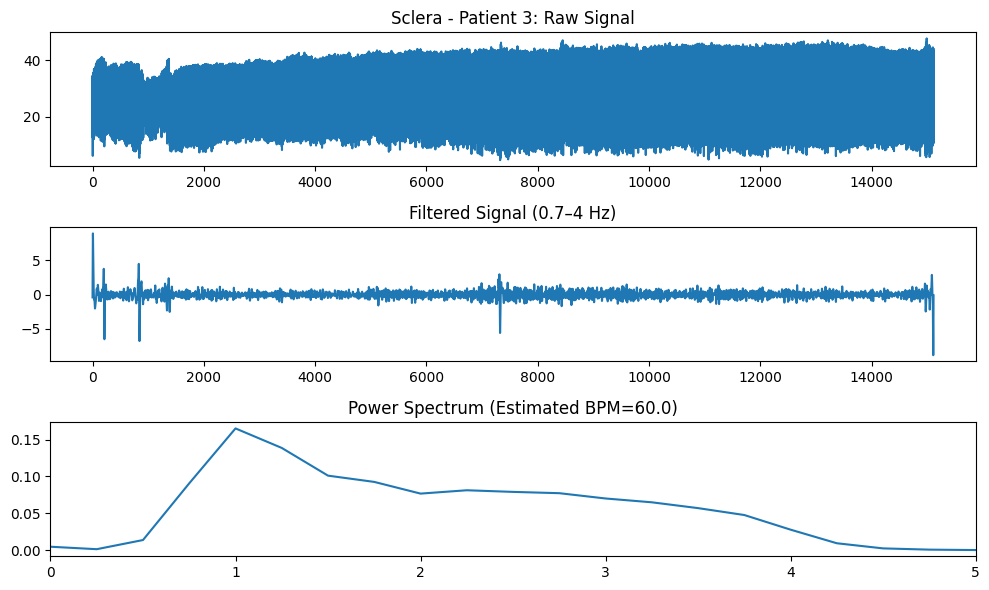

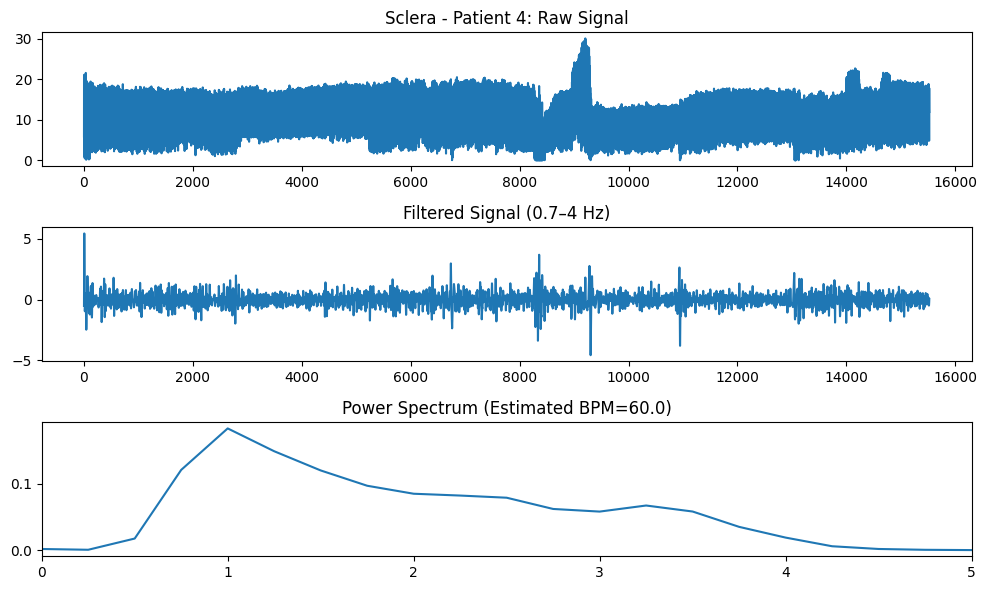

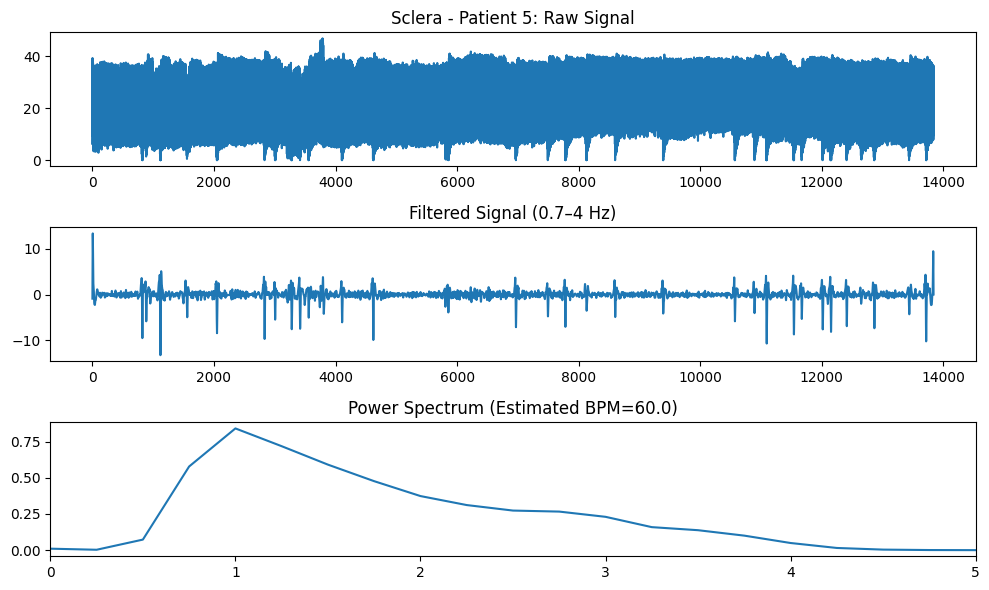


--- Estimated BPM Results ---
{'Region': 'Forehead', 'Patient': 1, 'BPM': 60.0}
{'Region': 'Forehead', 'Patient': 2, 'BPM': 45.0}
{'Region': 'Forehead', 'Patient': 3, 'BPM': 45.0}
{'Region': 'Forehead', 'Patient': 4, 'BPM': 45.0}
{'Region': 'Forehead', 'Patient': 5, 'BPM': 60.0}
{'Region': 'Sclera', 'Patient': 1, 'BPM': 60.0}
{'Region': 'Sclera', 'Patient': 2, 'BPM': 60.0}
{'Region': 'Sclera', 'Patient': 3, 'BPM': 60.0}
{'Region': 'Sclera', 'Patient': 4, 'BPM': 60.0}
{'Region': 'Sclera', 'Patient': 5, 'BPM': 60.0}


In [9]:
forehead_folder = "/kaggle/input/forehead"
sclera_folder = "/kaggle/input/sclera"

results = []
results = process_folder(forehead_folder, "Forehead", results)
results = process_folder(sclera_folder, "Sclera", results)

print("\n--- Estimated BPM Results ---")
for r in results:
    print(r)

In [10]:
import pandas as pd

df = pd.DataFrame(results)
df.to_csv("bpm_results.csv", index=False)
print(df)

     Region  Patient   BPM
0  Forehead        1  60.0
1  Forehead        2  45.0
2  Forehead        3  45.0
3  Forehead        4  45.0
4  Forehead        5  60.0
5    Sclera        1  60.0
6    Sclera        2  60.0
7    Sclera        3  60.0
8    Sclera        4  60.0
9    Sclera        5  60.0
